In [55]:
import pathlib
import torch
import torch.utils.data
import torchvision
import torch.nn as nn

from torchvision import datasets, tv_tensors
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from Loader_17 import normalize
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from deform_video import DeformLightVideoPos
from deform_model import get_batch_average_bou_iou
from polygon import RasLoss, SoftPolygon
import torch.optim as optim
import cv2 as cv
from preprocess_utensils import get_boundary_points, uniform_sample_points
import gc
from einops import rearrange, repeat

In [2]:
coco_val_img_path = pathlib.Path("./coco/val2017")
coco_val_ann_path = pathlib.Path("./coco/annotations/instances_val2017.json")

In [3]:
val_dataset = datasets.CocoDetection(coco_val_img_path, coco_val_ann_path)

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [79]:
coco_train_img_path = pathlib.Path("./coco/train2017")
coco_train_ann_path = pathlib.Path("./coco/annotations/instances_train2017.json")
train_dataset = datasets.CocoDetection(coco_train_img_path, coco_train_ann_path)

loading annotations into memory...
Done (t=15.03s)
creating index...
index created!


In [ ]:
wrap_val_dataset = datasets.wrap_dataset_for_transforms_v2(val_dataset, target_keys=["masks"])


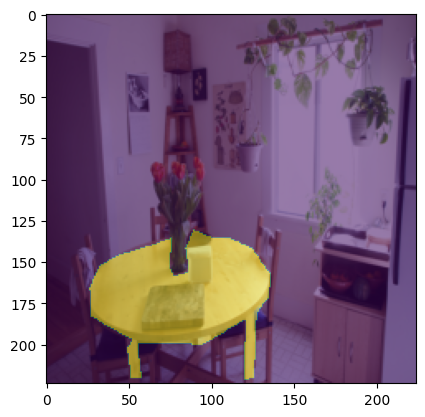

In [7]:
class PreTransformer:
    def __init__(self) -> None:
        self.img_transform = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Resize((224, 224)),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        self.mask_transform = v2.Compose(
            [
                v2.Resize((224, 224), interpolation="nearest"),
            ]
        )

    def __call__(
        self, img: Image.Image, mask: tv_tensors.Mask
    ) -> tuple[tv_tensors.Image, tv_tensors.Mask]:
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        return img, mask
    

pre_transformer = PreTransformer()
rand_idx = random.randint(0, len(wrap_val_dataset) - 1)
sample = wrap_val_dataset[rand_idx]
img, target = sample
mask = target["masks"]
rand_mask_idx = random.randint(0, len(target["masks"]) - 1)
resized_img, resized_mask = pre_transformer(img, mask)
plt.imshow(normalize(resized_img).permute(1, 2, 0))
plt.imshow(resized_mask[rand_mask_idx], alpha=0.5)

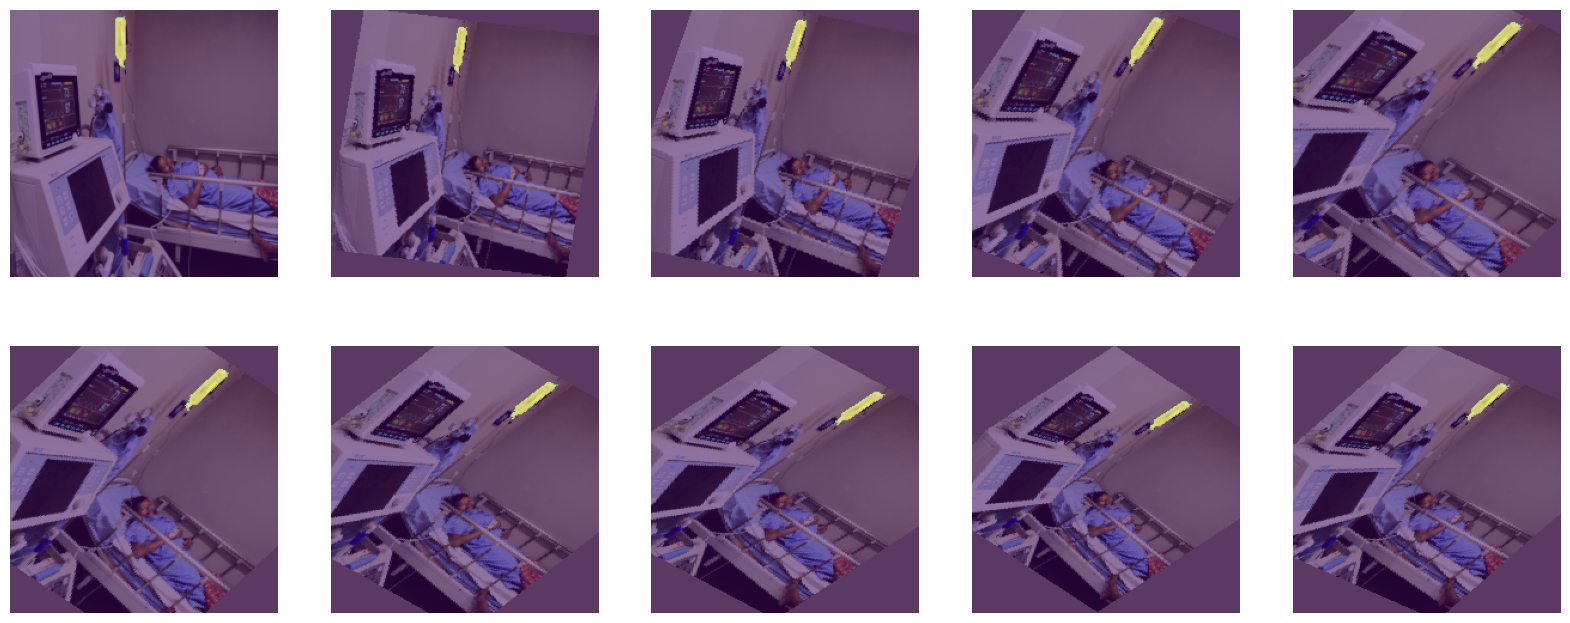

In [34]:
class AffineVideoGenerator:
    def __init__(self, frame_num: int) -> None:
        self.shift_params = dict(
            angle=(-10, 10),
            translate=(-0.05, 0.05),
            scale=(-0.1, 0.1),
            shear=(-10, 10),
        )
        self.frame_num = frame_num

    def __call__(self, img: tv_tensors.Image, mask: tv_tensors.Mask) -> tuple[
        tuple[tv_tensors.Image, tv_tensors.Mask],
        tuple[tv_tensors.Image, tv_tensors.Mask],
    ]:
        shift_angle = 0
        shift_translate = (0, 0)
        shift_scale = 1
        shift_shear = 0
        imgs = [img]
        masks = [mask]
        for i in range(1, self.frame_num):
            shift_angle += random.uniform(*self.shift_params["angle"])
            shift_translate = (
                shift_translate[0] + random.uniform(*self.shift_params["translate"]),
                shift_translate[1] + random.uniform(*self.shift_params["translate"]),
            )
            shift_scale += random.uniform(*self.shift_params["scale"])
            shift_shear += random.uniform(*self.shift_params["shear"])
            if shift_scale < 0.1:
                shift_scale = 0.1
            imgs.append(
                v2.functional.affine(
                    img,
                    angle=shift_angle,
                    translate=shift_translate,
                    scale=shift_scale,
                    shear=shift_shear,
                )
            )
            masks.append(
                v2.functional.affine(
                    mask,
                    angle=shift_angle,
                    translate=shift_translate,
                    scale=shift_scale,
                    shear=shift_shear,
                )
            )
        return (imgs, masks)

frame_num = 10
video_generator = AffineVideoGenerator(frame_num)
rand_idx = random.randint(0, len(wrap_val_dataset) - 1)
sample = wrap_val_dataset[rand_idx]
img, target = sample
mask = target["masks"]
rand_mask_idx = random.randint(0, len(target["masks"]) - 1)
resized_img, resized_mask = pre_transformer(img, mask)
imgs, masks = video_generator(resized_img, resized_mask)
# show all frames in the video
# each line shows 5 frames
fig, axes = plt.subplots(frame_num // 5, 5, figsize=(20, 4 * (frame_num // 5)))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = axes[i // 5, i % 5]
    ax.imshow(normalize(img).permute(1, 2, 0))
    ax.imshow(mask[rand_mask_idx], alpha=0.5)
    ax.axis("off")
plt.show()



In [84]:
class CocoVideoDataset(Dataset):
    def __init__(
        self,
        dataset: datasets.CocoDetection,
        small_subset=False,
        point_num=32,
        frame_num=10,
        dataset_size=None,
    ) -> None:
        super().__init__()
        self.pre_transformer = PreTransformer()
        self.video_generator = AffineVideoGenerator(frame_num)
        self.point_num = point_num
        self.dataset = datasets.wrap_dataset_for_transforms_v2(
            dataset, target_keys=["masks"]
        )
        if small_subset:
            self.dataset = torch.utils.data.Subset(self.dataset, range(10))
        self.gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
        self.dataset_size = dataset_size

    def __len__(self) -> int:
        if self.dataset_size is not None:
            return self.dataset_size
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # randomly choose one image
        def _get_new_idx():
            while True:
                random.seed()
                idx = random.randint(0, len(self.dataset) - 1)
                sample = self.dataset[idx]
                if "masks" in sample[1]:
                    return idx

        def _get_boundary_points(mask: torch.Tensor) -> torch.Tensor:
            boundary = get_boundary_points(mask.numpy())
            boundary = uniform_sample_points(boundary, self.point_num)
            boundary = torch.tensor(boundary, dtype=torch.float32)
            return boundary

        while True:
            idx = _get_new_idx()
            sample = self.dataset[idx]
            img, target = sample
            mask = target["masks"]
            resized_img, resized_mask = self.pre_transformer(img, mask)
            rand_mask_idx = random.randint(0, len(resized_mask) - 1)
            resized_mask = tv_tensors.Mask(resized_mask[rand_mask_idx])
            imgs, masks = self.video_generator(resized_img, resized_mask)
            # check if all masks are valid
            if all(mask.sum() > 0 for mask in masks):
                points = []
                for mask in masks:
                    boundary_points = _get_boundary_points(mask)
                    points.append(boundary_points)
                # check if all points' shape is (point_num, 2)
                if all(point.shape == (self.point_num, 2) for point in points):
                    break
        imgs = torch.stack(imgs)
        masks = torch.stack(masks)
        points = torch.stack(points)
        return imgs, masks, points

In [87]:
my_dataset = CocoVideoDataset(val_dataset, small_subset=False, dataset_size=100)

In [88]:
my_loader = DataLoader(my_dataset, batch_size=1, shuffle=True)

In [89]:
imgs, masks, points = next(iter(my_loader))
imgs.shape, masks.shape, points.shape

(torch.Size([1, 10, 3, 224, 224]),
 torch.Size([1, 10, 224, 224]),
 torch.Size([1, 10, 32, 2]))

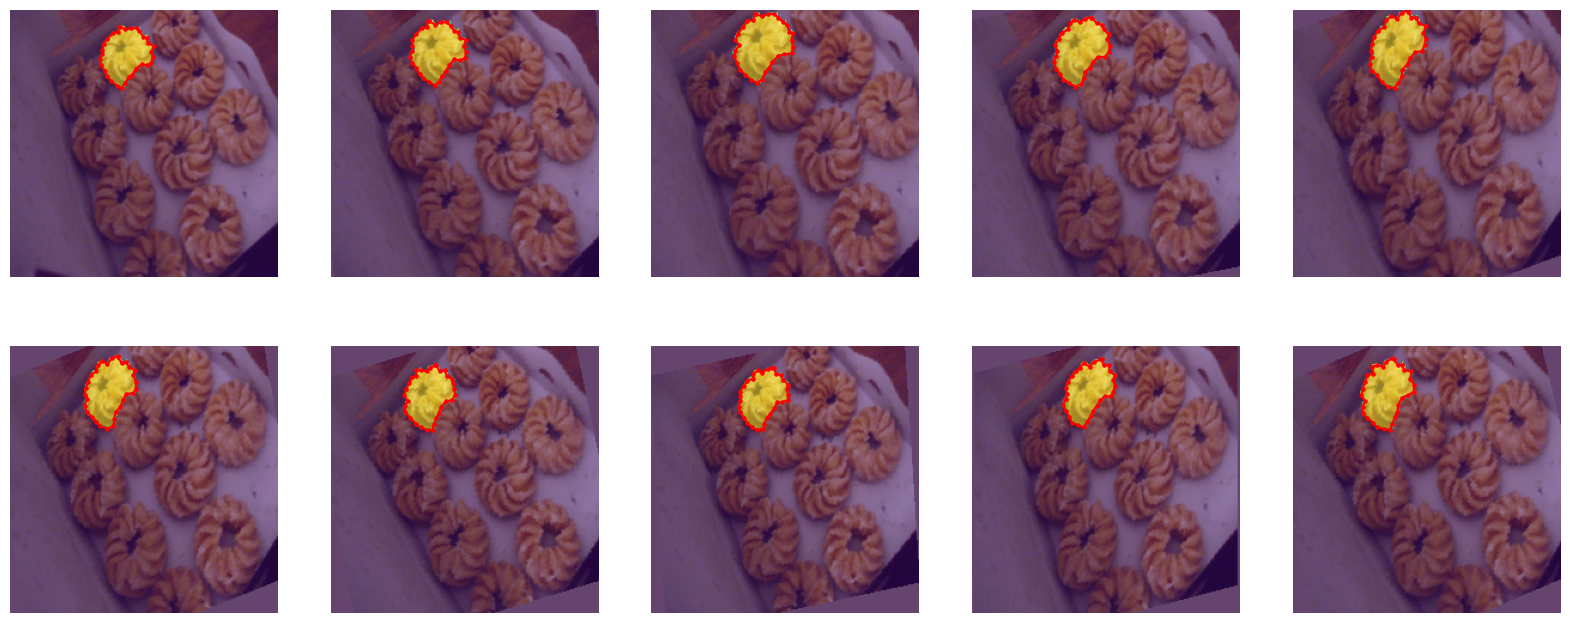

In [90]:
# show all frames in the video and the polygon
frame_num = imgs.shape[1]
fig, axes = plt.subplots(frame_num // 5, 5, figsize=(20, 4 * (frame_num // 5)))
for i in range(frame_num):
    ax = axes[i // 5, i % 5]
    ax.imshow(normalize(imgs[0, i]).permute(1, 2, 0))
    ax.imshow(masks[0, i], alpha=0.5)
    ax.plot(points[0, i, :, 0], points[0, i, :, 1], c="r")
    ax.scatter(points[0, i, :, 0], points[0, i, :, 1], c="r", s=5)
    ax.axis("off")

In [91]:
fir_point = points[:, 0]
init_points = repeat(fir_point, "b n p -> b f n p", f=frame_num)
init_points.shape

torch.Size([1, 10, 32, 2])

In [92]:
from cotracker import Cotracker, VideoLoss

In [93]:
model = Cotracker(32).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [94]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [95]:
epoch_num = 5

In [96]:
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
ras_loss = RasLoss().cuda()
video_loss = VideoLoss(ras_loss, gt_rasterizer).cuda()

In [100]:
masks.shape[1]

10

In [97]:
for e in range(epoch_num):
    model.train()
    total_loss = 0
    total_iou = 0
    for imgs, masks, points in tqdm(my_loader):
        imgs = imgs.cuda()
        masks = masks.cuda()
        points = points.cuda()
        optimizer.zero_grad()
        fir_point = points[:, 0]
        init_points = repeat(fir_point, "b n p -> b f n p", f=frame_num)
        pred_points = model(imgs.cuda(), init_points.cuda())
        target_masks = masks[:, 1:]
        loss, iou = video_loss(pred_points, target_masks.cuda())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()
    total_iou /= len(my_loader)
    total_loss /= len(my_loader)
    print(f"Epoch {e}, Loss: {total_loss:.4f}, IoU: {total_iou:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 0, Loss: 0.5513, IoU: 0.3307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 1, Loss: 0.5490, IoU: 0.3376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 2, Loss: 0.5592, IoU: 0.3271


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 3, Loss: 0.5620, IoU: 0.3249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]

Epoch 4, Loss: 0.5254, IoU: 0.3558


In [80]:
full_val_dataset = CocoVideoDataset(val_dataset)
full_val_loader = DataLoader(full_val_dataset, batch_size=1, shuffle=True)

In [81]:
for imgs, masks, points in tqdm(full_val_loader):
    pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:16<00:00, 19.47it/s]


In [85]:
full_train_dataset = CocoVideoDataset(train_dataset, dataset_size=100)
full_train_loader = DataLoader(full_train_dataset, batch_size=1, shuffle=True)

In [86]:
for imgs, masks, points in tqdm(full_train_loader):
    pass

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.46it/s]
